# Customer Churn Prediction – Telco Dataset

**Dataset Link:** [https://www.kaggle.com/datasets/blastchar/telco-customer-churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)

Goal<br>
"Predict behavior to retain customers. Analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]


- Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

## Import libraries

In [65]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from collections import Counter

from IPython.display import clear_output

!pip install shap
import shap
from sklearn.linear_model import LogisticRegression
from statsmodels.api import add_constant
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error, r2_score

from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

clear_output()
warnings.filterwarnings('ignore')


## Exploratory Analysis

In [ ]:
# Load the dataset again to define 'df'
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Display dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [67]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [68]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [69]:
for col in ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']:
   print(col, ':', df[col].unique())

MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [70]:
# Extract number and letter parts
df['CustomerNumber'] = df['customerID'].str.extract(r'(\d+)', expand=False)
df['CustomerCode'] = df['customerID'].str.extract(r'([A-Z]+)', expand=False)
df['CustomerNumber'] = df['CustomerNumber'].astype(int)
df['MultipleLines'].unique()

array(['No phone service', 'No', 'Yes'], dtype=object)

In [71]:
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
CustomerNumber       0
CustomerCode         0
dtype: int64

In [72]:
df.drop(labels=df[pd.isnull(df['TotalCharges'])].index, axis=0, inplace=True)

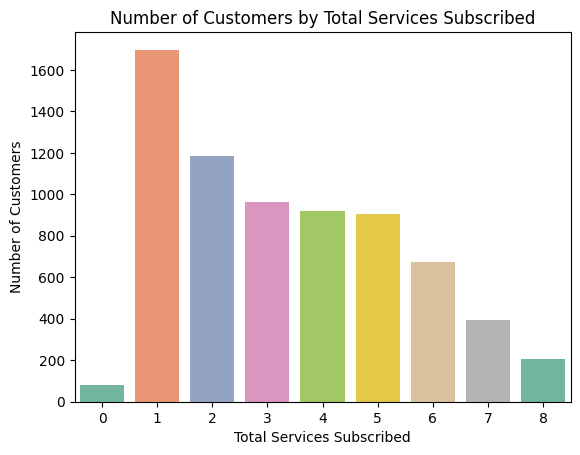

In [73]:
# Define the list of service-related columns
total_services = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Convert 'Yes'/'No' values to 1/0 for the service-related columns
df[total_services] = df[total_services].applymap(lambda x: 1 if x == 'Yes' else 0)
df['TotalServices'] = df[total_services].sum(axis=1)
df['TotalServices'].value_counts()

sns.countplot(x='TotalServices', data=df, palette='Set2')
plt.title('Number of Customers by Total Services Subscribed')
plt.xlabel('Total Services Subscribed')
plt.ylabel('Number of Customers')
plt.show()



<Axes: xlabel='TotalServices', ylabel='count'>

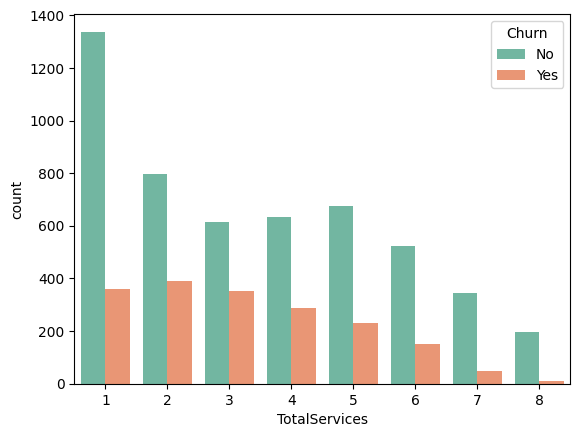

In [74]:
df = df[df['TotalServices'] > 0].copy()
sns.countplot(x='TotalServices', data=df, hue='Churn', palette='Set2')

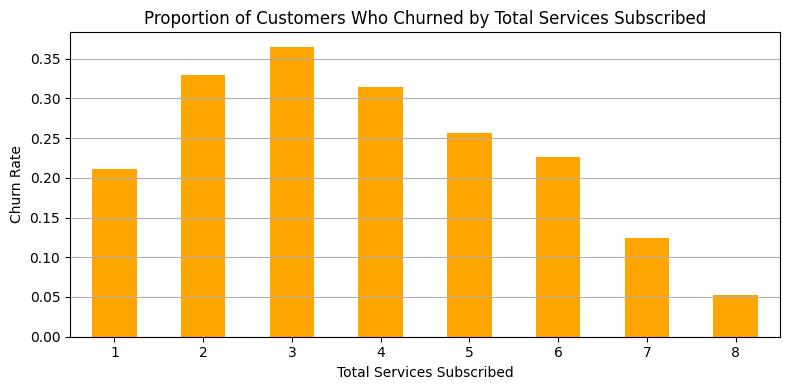

In [75]:
# 1. Create a new DataFrame with % churn per TotalServices group
df = df[df['TotalServices'] > 0].copy()

churn_by_services = (
    df.groupby('TotalServices')['Churn']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .rename(columns={'Yes': 'Churn', 'No': 'No Churn'})
)

# 2. Plot only the % of churned customers
churn_by_services['Churn'].plot(kind='bar', color='orange', figsize=(8, 4))
plt.title('Proportion of Customers Who Churned by Total Services Subscribed')
plt.xlabel('Total Services Subscribed')
plt.ylabel('Churn Rate')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()



- Customers with fewer subscribed services (less than 4) are more likely to churn.
- Customers using multiple services are stickier, showing lower churn probability.

<h2> EDA

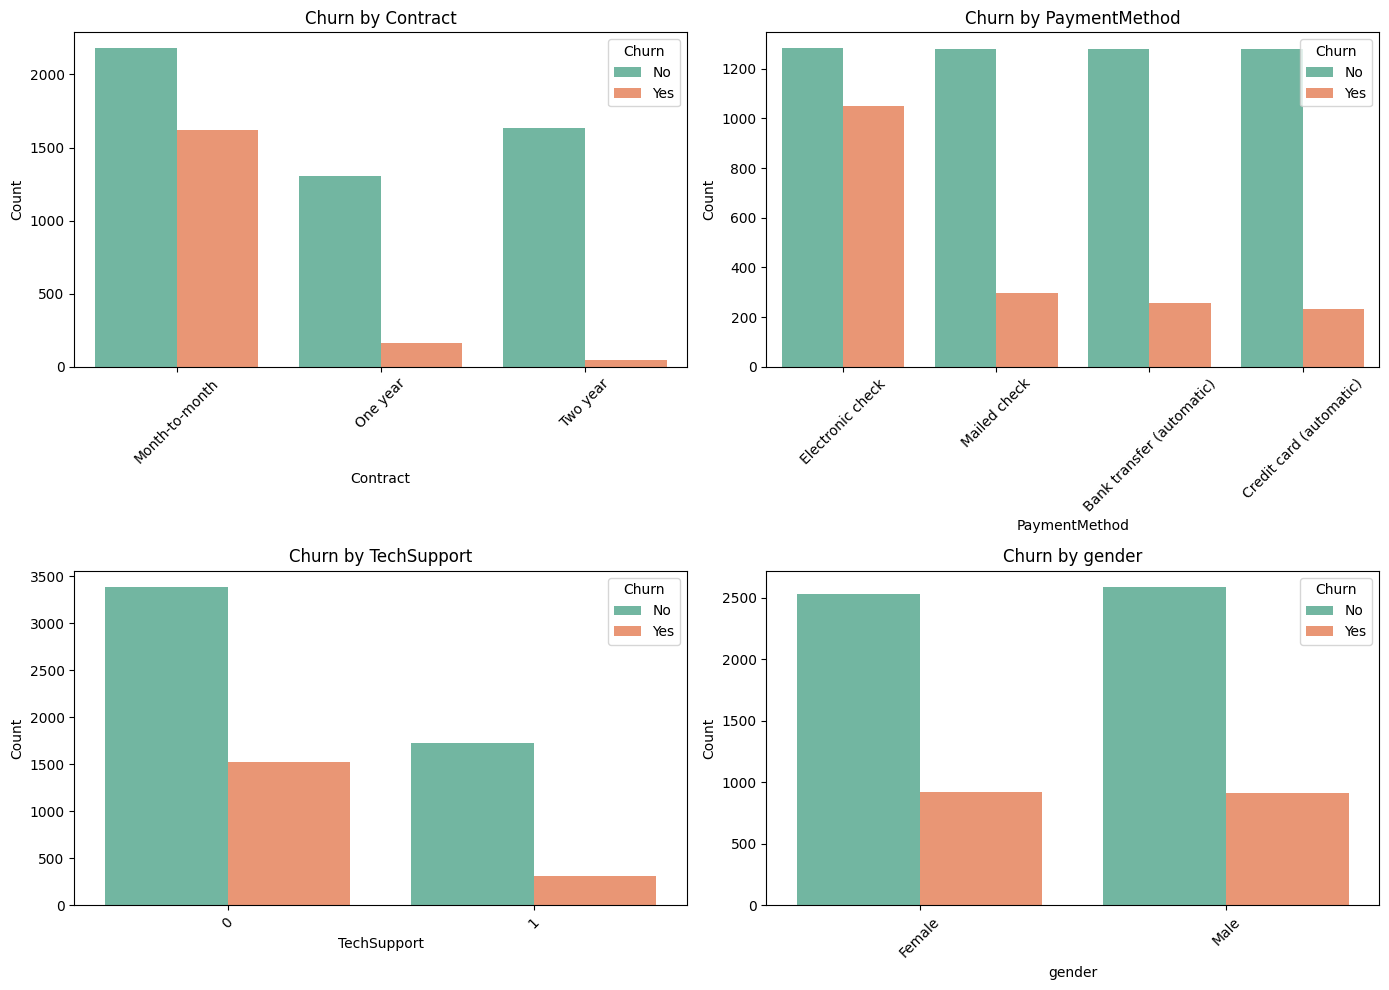

In [76]:
categorical_features = ['Contract', 'PaymentMethod', 'TechSupport', 'gender']
n_features = len(categorical_features)

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # flatten 2D array to 1D for easy looping

for i, col in enumerate(categorical_features):
    sns.countplot(data=df, x=col, hue='Churn', palette='Set2', ax=axes[i])
    axes[i].set_title(f'Churn by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

# Adjust layout and spacing
plt.tight_layout()
plt.show()

<h4> Insights from Churn Breakdown by Key Features</h4>

1. <b>Contract Type</b> Two-year contracts</strong> show the <em>lowest churn rate</em> — likely due to higher commitment or cancellation friction. Month-to-month customers</strong> churn at the <em>highest rate</em>, suggesting flexibility increases churn risk.</li>

2. <b>Internet Service </b>Customers using <strong>fiber optic service</strong> are <em>more likely to churn</em> than DSL or those without internet service. This may indicate dissatisfaction with service performance or pricing sensitivity.</li>

3. <b>Payment Method</b> Electronic check users show higher churn rates than those with automatic payment methods.This could reflect lower engagement or financial friction.

4. <b> Tech Support</b>Customers with <strong>active tech support</strong> are <em>less likely to churn. Access to support may reinforce satisfaction and retention.</li>

<b>Strategic Implications</b>
<ul>
  <li>- Promote <strong>longer-term contracts</strong> with incentives.</li>
  <li>- Address potential issues with <strong>fiber optic service</strong>.</li>
  <li>- Encourage <strong>automatic payments</strong> (e.g., via small discounts).</li>
  <li>- Expand <strong>tech support outreach</strong> to reduce churn risk.</li>
</ul>


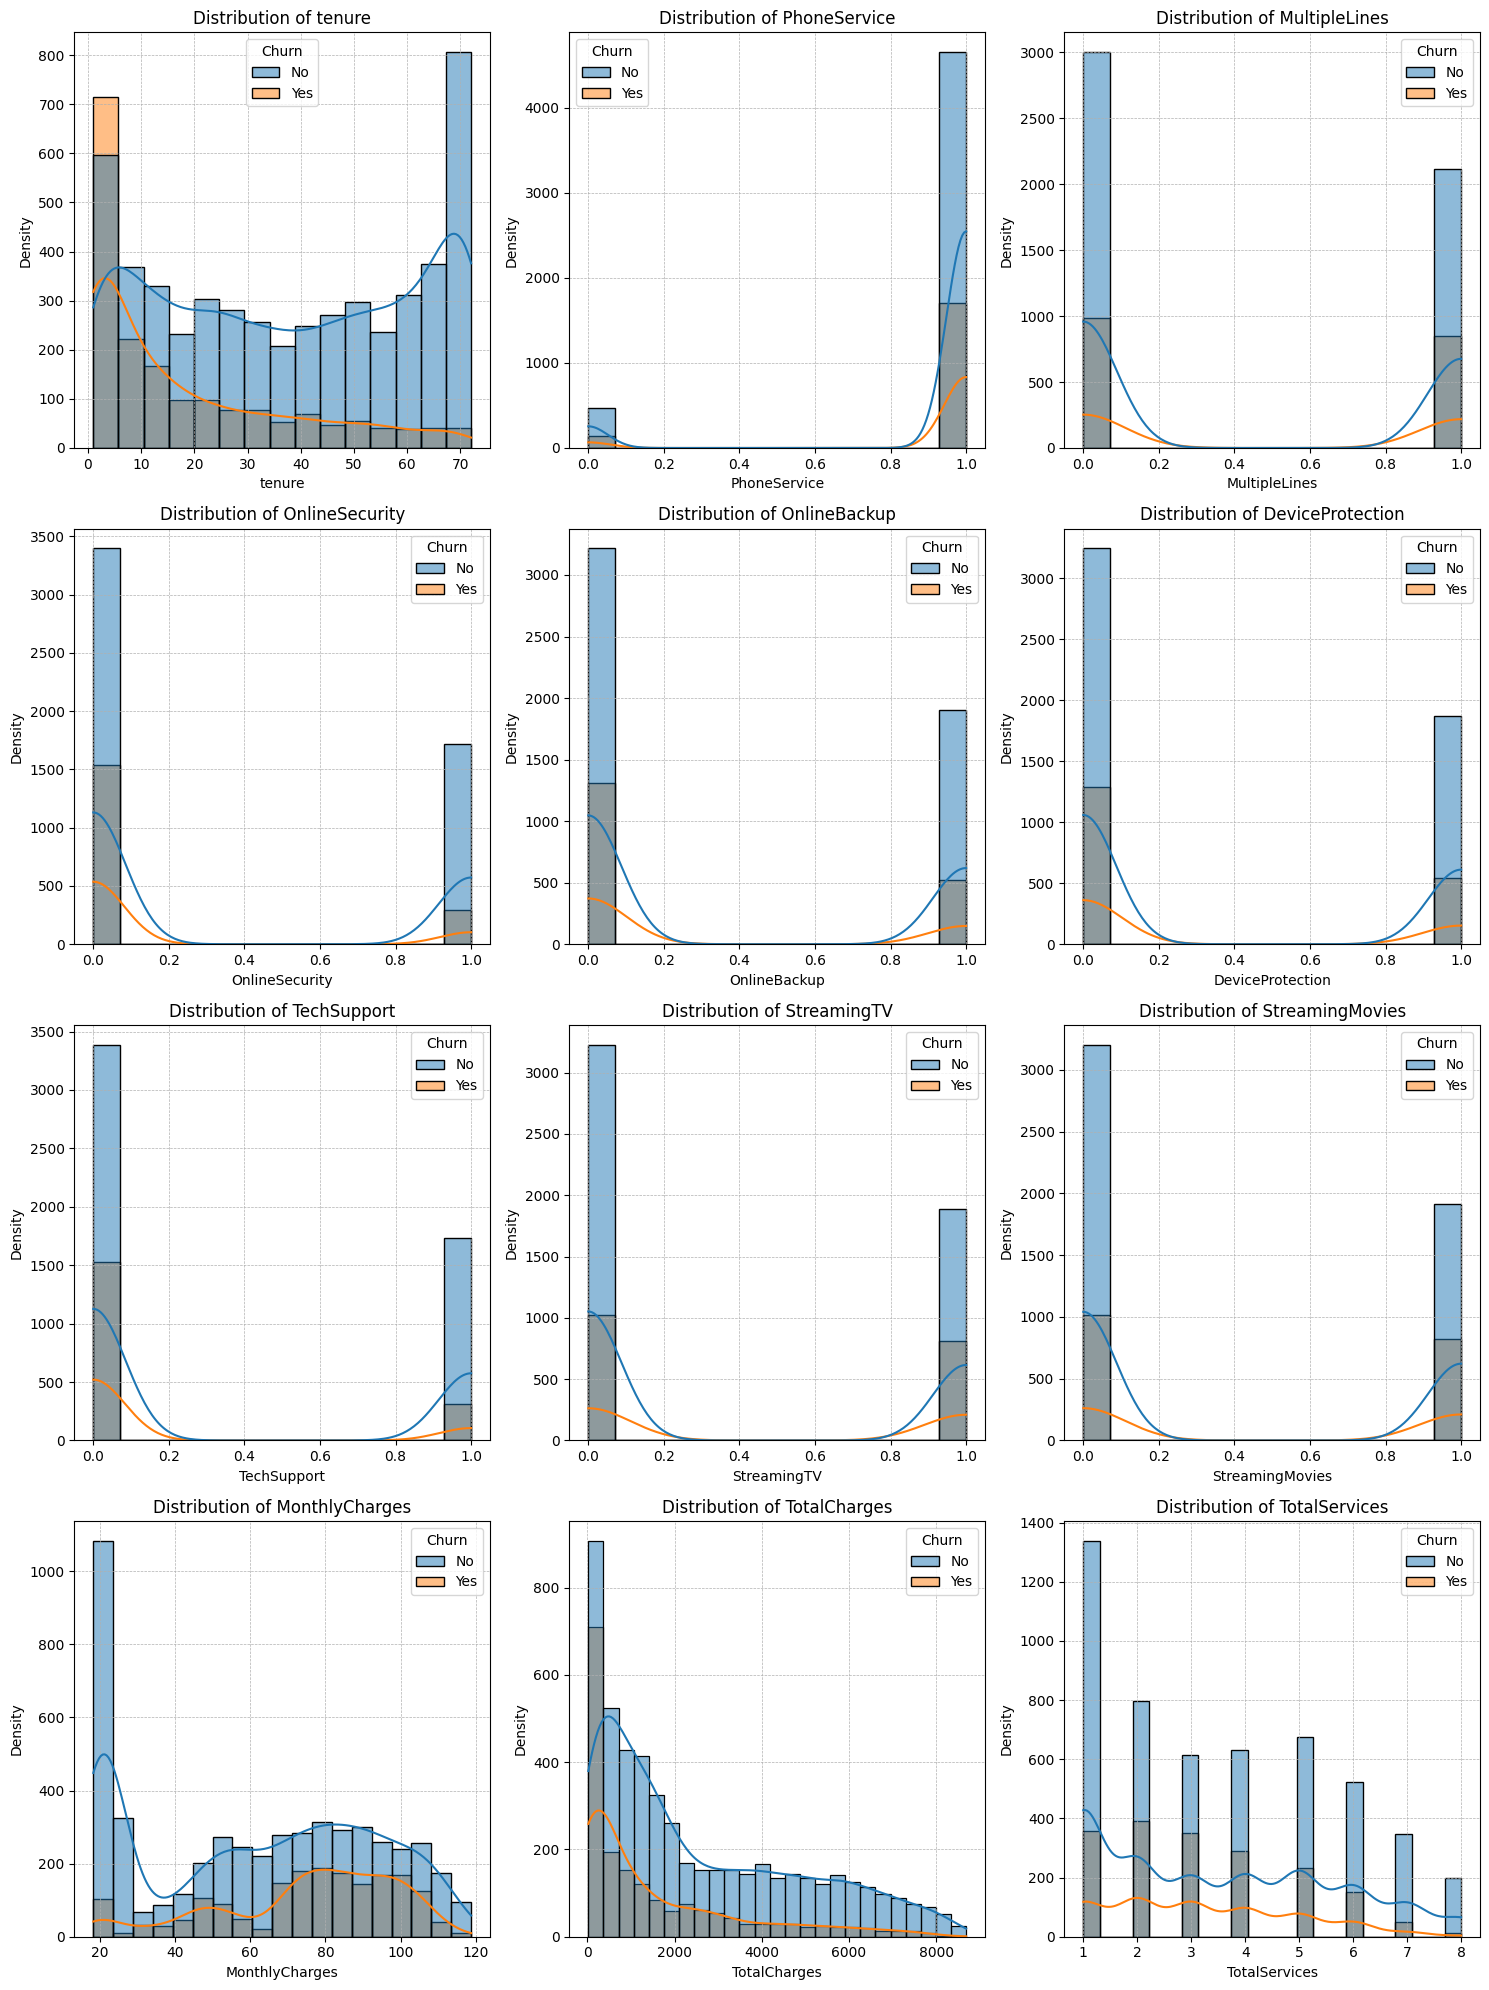

In [77]:
# Histogram of numerical variables

# Numerical features
numericals = df.select_dtypes(include=[np.number]).drop(columns=['CustomerNumber', 'SeniorCitizen'])

# Remove columns with constant values or very low variance
numericals = numericals.loc[:, numericals.var() > 1e-5]

# Layout
plots_per_row = 3
num_features = len(numericals.columns)
num_rows = (num_features + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 5, num_rows * 5))
axes = axes.flatten()

# Define a color palette
palette = sns.color_palette("muted")

# Loop and plot
for idx, col in enumerate(numericals.columns):
    ax = axes[idx]
    
    # Full dataset - light gray background histogram
    sns.histplot(data=df, x=col, ax=ax, color=palette[idx % len(palette)], hue='Churn', kde=True)
    
    ax.set_title(f'Distribution of {col}', fontsize=12)
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
    ax.grid(True, linestyle='--', linewidth=0.5)

# Remove unused subplots
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Encode categorical variables (LabelEncoding, OneHotEncoding)

- Binary (Yes/No or 0/1) → Label Encode
- Map special Yes/No/None columns to 1/0/np.nan
- One-hot encode multi-class categoricals - pd.get_dummies
- Convert 'TotalCharges' to numeric and fill missing
- Scale numeric features
- Final clean-up (Drop any remaining missing rows)**



In [78]:

# Copy original dataframe
df_encoded = df.copy()

# Remove redundant features
df_encoded = df_encoded.drop(columns=['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'])

# -------------------------------
# 1. Handle binary features (Yes/No)
# -------------------------------
binary_map = {'Yes': 1, 'No': 0}
binary_cols = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn']

for col in binary_cols:
    df_encoded[col] = df_encoded[col].map(binary_map)

# -------------------------------
# 2. One-hot encode multi-class categoricals
# -------------------------------
multiclass_cols = ['gender', 'Contract', 'PaymentMethod']

df_encoded = pd.get_dummies(df_encoded, columns=multiclass_cols, drop_first=True)



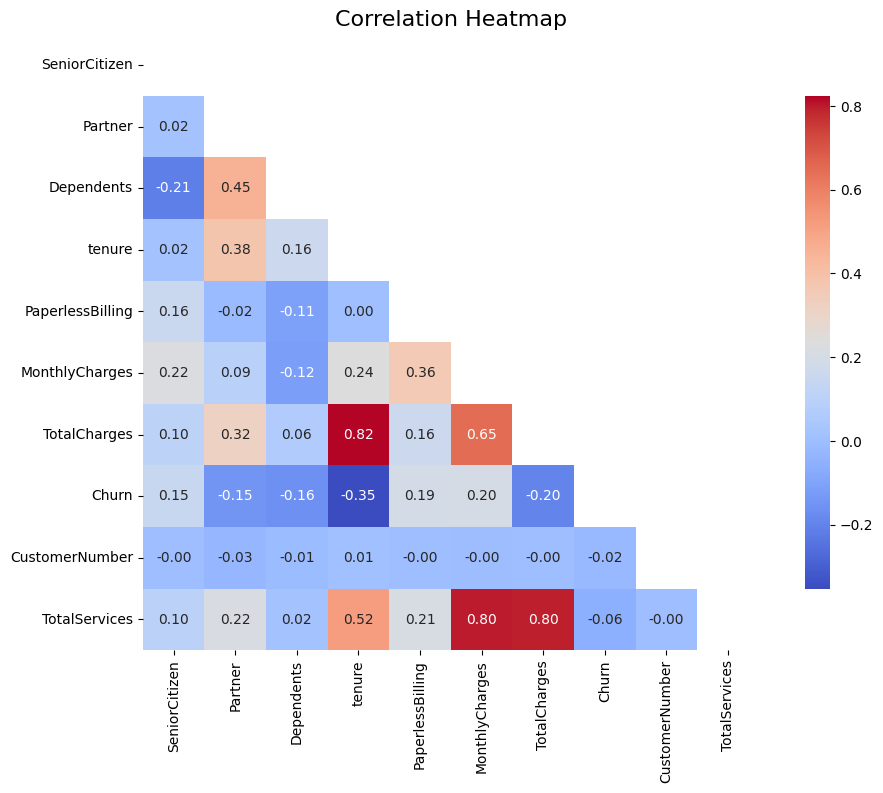

In [79]:

# Correlation heatmap (numeric and encoded)
plt.figure(figsize=(12, 8))

# Drop non-numeric columns before calculating the correlation matrix
numeric_df = df_encoded.select_dtypes(include=[np.number])
corr = numeric_df.corr()

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap', fontsize=16)
plt.show()


In [80]:
# 1. Calculate correlation matrix
columns_to_drop = ['CustomerNumber', 'CustomerCode', 'customerID']
columns_to_drop = [col for col in columns_to_drop if col in df_encoded.columns]

corr = df_encoded.drop(columns=columns_to_drop).select_dtypes(include=[np.number]).corr()

# 2. Flatten and clean correlation pairs
corr_pairs = corr.unstack()
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# 3. Drop duplicate pairs: (A, B) and (B, A)
# Convert multi-index to sorted tuple so (A, B) == (B, A)
corr_pairs.index = [tuple(sorted(pair)) for pair in corr_pairs.index]
corr_pairs = corr_pairs[~corr_pairs.index.duplicated(keep='first')]

# 4. Sort by absolute correlation values
sorted_corr = corr_pairs.abs().sort_values(ascending=False)

print("\nTop Absolute Correlations:\n")
print(sorted_corr.head(10))



Top Absolute Correlations:

(TotalCharges, tenure)                0.824578
(MonthlyCharges, TotalServices)       0.797774
(TotalCharges, TotalServices)         0.795910
(MonthlyCharges, TotalCharges)        0.646881
(TotalServices, tenure)               0.517809
(Dependents, Partner)                 0.453656
(Partner, tenure)                     0.379696
(MonthlyCharges, PaperlessBilling)    0.356681
(Churn, tenure)                       0.352576
(Partner, TotalCharges)               0.316843
dtype: float64


In [81]:
df_encoded = df_encoded.drop(columns=['Dependents']) 

In [82]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Filter only numeric columns (VIF requires numerical input)
numeric_cols = df_encoded.drop(columns=['Churn', 'CustomerNumber', 'CustomerCode']).select_dtypes(include=['int64', 'float64'])

# Calculate VIF
vif_data = calculate_vif(numeric_cols)
print(vif_data.sort_values(by='VIF', ascending=False))

            feature        VIF
6     TotalServices  16.920415
4    MonthlyCharges  14.513281
5      TotalCharges   9.930224
2            tenure   7.658812
3  PaperlessBilling   2.851598
1           Partner   2.235094
0     SeniorCitizen   1.287150


In [83]:
# Drop unnecessary or ID-like columns and features with high VIF
columns_to_drop = ['MonthlyCharges', 'customerID', 'CustomerCode', 'CustomerNumber']
columns_to_drop = [col for col in columns_to_drop if col in df_encoded.columns]  # Check if columns exist
df_encoded = df_encoded.drop(columns=columns_to_drop)

# Ensure 'Churn' is at the end so we can isolate it
target = 'Churn'
df_corr_target = df_encoded.corr()  # Calculate the correlation matrix
feature_corr = df_corr_target[target].drop(target).sort_values()

important_corr = feature_corr[feature_corr.abs() > 0.2]
print("\nFeatures with correlation > 0.2 in magnitude:\n")
print(important_corr.sort_values(ascending=False))



Features with correlation > 0.2 in magnitude:

PaymentMethod_Electronic check    0.300581
Contract_Two year                -0.302024
tenure                           -0.352576
Name: Churn, dtype: float64


## Scale numerical features (StandardScaler)

In [84]:
df_encoded.columns

Index(['SeniorCitizen', 'Partner', 'tenure', 'PaperlessBilling',
       'TotalCharges', 'Churn', 'TotalServices', 'gender_Male',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [85]:
df_encoded.head()

,SeniorCitizen,Partner,tenure,PaperlessBilling,TotalCharges,Churn,TotalServices,gender_Male,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,1,1,29.85,0,1,False,False,False,False,True,False
1,0,0,34,0,1889.50,0,3,True,True,False,False,False,True
2,0,0,2,1,108.15,1,3,True,False,False,False,False,True
3,0,0,45,0,1840.75,0,3,True,True,False,False,False,False
4,0,0,2,1,151.65,1,1,False,False,False,False,True,False


In [86]:
num_cols = ['tenure', 'TotalServices', 'TotalCharges']


# Scale
scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

# Drop rows with any remaining NA
df_encoded = df_encoded.dropna()


## Handle class imbalance 

<h4> SMOTE</h4>

    - SMOTE (Synthetic Minority Over-sampling Technique) 
Generates synthetic examples for the minority class (e.g., Churn = Yes). Helps models avoid being biased, 
thus potentially improving recall and generalization.

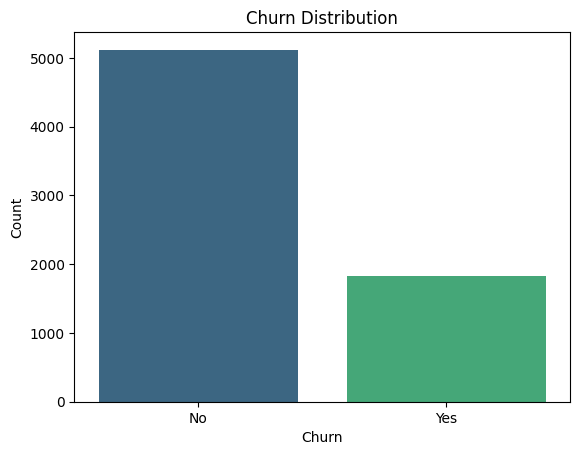

Churn
No     5118
Yes    1834
Name: count, dtype: int64

Churn Rate: 26.38%
...........................


In [87]:
# Plot the distribution of churn
sns.countplot(x='Churn', data=df, palette='viridis')
clear_output()

plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# Check for class imbalance
churn_counts = df['Churn'].value_counts()
print(churn_counts)
print()
# Calculate and print churn rate
churn_rate = (churn_counts[1] / churn_counts.sum()) * 100

print(f"Churn Rate: {churn_rate:.2f}%")
print("...........................")

<p>This imbalance can trick many classifiers into thinking they're performing well just by predicting <strong><color= red>"No"</red></strong> most of the time — even though:</p>

<ul>
  <li><strong>Accuracy</strong> may appear high</li>
  <li><strong>Recall/Precision</strong> for churners can be very poor</li>
</ul>

--

<h2> SMOTE

In [88]:

# Define features and target
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

# Step 1: Split data before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Apply SMOTE only on training data (not test)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Step 3: Check class distribution before and after SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts(), end="\n\n")

print("Class distribution after SMOTE:")
print(y_train_bal.value_counts(), end="\n\n")

Class distribution before SMOTE:
Churn
0    4094
1    1467
Name: count, dtype: int64

Class distribution after SMOTE:
Churn
0    4094
1    4094
Name: count, dtype: int64



## Model 1 (RandomForestClassifier)

<h4>Why Random Forest Is a Strong Baseline for Churn Prediction</h3>
  <li>Handles both categorical and numerical variables</strong> (once encoded)</li>
  <li>Robust to outliers and missing values</strong> (in training)</li>
  <li><Reduces overfitting</strong> by averaging multiple decision trees</li>
  <li><Provides feature importances,</strong> making it great for business insights</li>
</ul>


In [89]:
# 1. Convert boolean columns in SMOTE-balanced training set
X_train_bal = X_train_bal.copy()
for col in X_train_bal.select_dtypes(include=['bool']).columns:
    X_train_bal[col] = X_train_bal[col].astype(int)

X_test = X_test.copy()
for col in X_test.select_dtypes(include=['bool']).columns:
    X_test[col] = X_test[col].astype(int)


# Train model

max_iter = 2000
    
    # Train model
model = LogisticRegression(class_weight='balanced', max_iter=max_iter, random_state=42)
model.fit(X_train_bal, y_train_bal)
    
    # Evaluate
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)
    
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.67      0.78      1024
           1       0.48      0.84      0.61       367

    accuracy                           0.71      1391
   macro avg       0.70      0.76      0.69      1391
weighted avg       0.81      0.71      0.73      1391

ROC AUC Score: 0.837386378150545
Confusion Matrix:
 [[684 340]
 [ 57 310]]


## Try other models (Random Forest, XGBoost)



<h4> Model 2: XGBoost with scale_pos_weight

In [90]:
# Separate final features and target
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Convert all columns to float64
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

# Confirm
print(X_train.dtypes.value_counts())

float64    12
Name: count, dtype: int64


In [91]:
from xgboost import XGBClassifier

# Calculate scale_pos_weight: ratio of negative to positive classes
neg, pos = y_train_bal.value_counts()
scale_ratio = neg / pos

# Define and train the XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_ratio,
    random_state=42,
    verbosity=0)

# Ensure data is clean and properly formatted
X_train_bal = X_train_bal.astype('float64').fillna(0)
X_test = X_test[X_train_bal.columns].astype('float64').fillna(0)

# Define the evaluate_model function
def evaluate_model(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Fit and evaluate the model
try:
    xgb_model.fit(X_train_bal, y_train_bal)
    evaluate_model(xgb_model, X_test, y_test)
except Exception as e:
    print("XGBoostError:", e)




Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1024
           1       0.54      0.72      0.61       367

    accuracy                           0.76      1391
   macro avg       0.71      0.75      0.72      1391
weighted avg       0.79      0.76      0.77      1391

ROC AUC Score: 0.8267971943119891
Confusion Matrix:
 [[796 228]
 [103 264]]


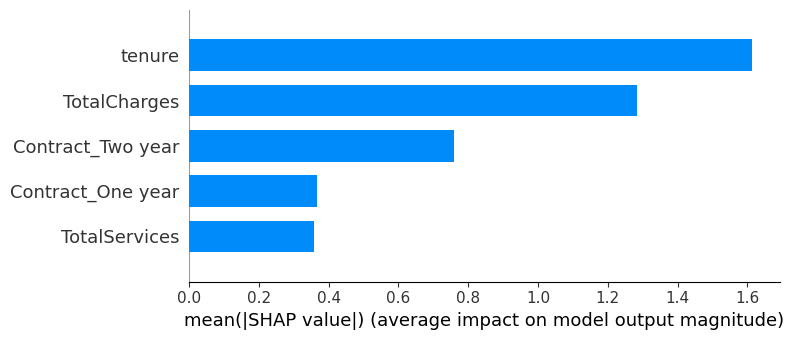

In [92]:
import shap
explainer = shap.TreeExplainer(xgb_model)  # or rf_model
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(12, 5))  
# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=5)

<h4> Model 3: Logistic Regression with class_weight='balanced'

In [93]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)  # no SMOTE needed here

evaluate_model(log_model, X_test, y_test)



Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.67      0.78      1024
           1       0.48      0.85      0.61       367

    accuracy                           0.72      1391
   macro avg       0.70      0.76      0.69      1391
weighted avg       0.81      0.72      0.73      1391

ROC AUC Score: 0.8357365995401909
Confusion Matrix:
 [[685 339]
 [ 56 311]]


In [94]:
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model
lr = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

# Only include interaction terms, not higher powers
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_train_inter = poly.fit_transform(X_train)
X_test_inter = poly.transform(X_test)

# Retrain
lr.fit(X_train_inter, y_train)
evaluate_model(lr, X_test_inter, y_test)



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      1024
           1       0.48      0.85      0.61       367

    accuracy                           0.72      1391
   macro avg       0.70      0.76      0.70      1391
weighted avg       0.81      0.72      0.73      1391

ROC AUC Score: 0.8344686648501362
Confusion Matrix:
 [[686 338]
 [ 55 312]]


## Reflect on results 

Despite trying:Feature selection (RFE), Interaction terms (PolynomialFeatures)

…the model’s precision for churners (class 1) remained low (~0.54), and AUC plateaued around 0.79–0.80. 
This indicates:
- Reaching the Limits of What Logistic Regression Can Learn
- these models assumes a straight-line relationship between inputs and log-odds of churn.
- Churn behavior is nonlinear and interaction-driven (e.g., contract type + tenure + monthly charges) in this case

Switch to a nonlinear model like Random Forest.

<h3> Model 4: Random Forest

In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Initialize Random Forest with class weight to handle imbalance
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1024
           1       0.58      0.49      0.53       367

    accuracy                           0.77      1391
   macro avg       0.70      0.68      0.69      1391
weighted avg       0.76      0.77      0.77      1391

ROC AUC Score: 0.8111495763794279
Confusion Matrix:
[[894 130]
 [187 180]]


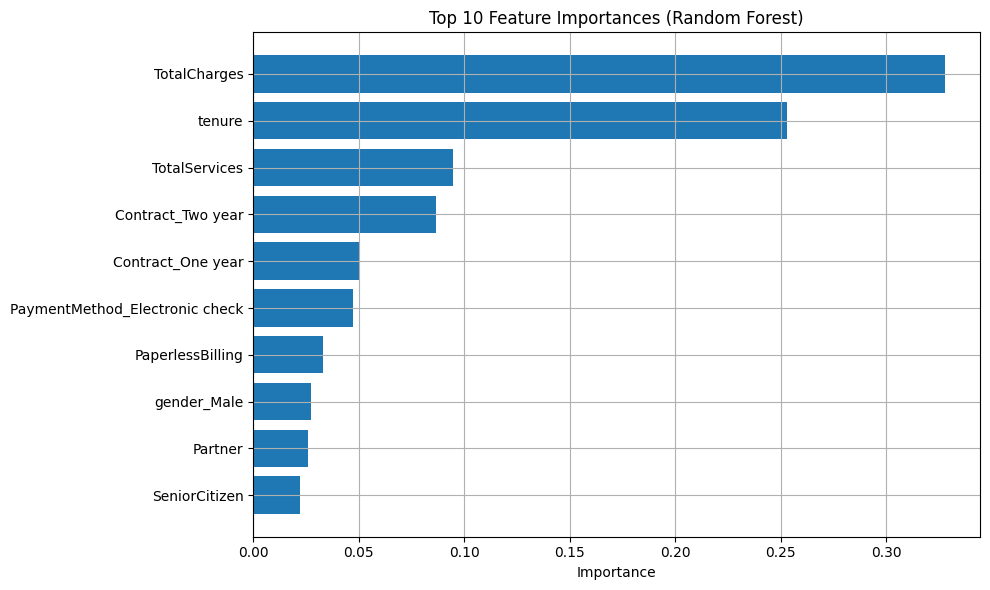

In [96]:
# Feature importances from Random Forest
importances = rf_model.feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(importances)[-10:]  # Top 10

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [97]:
from sklearn.svm import SVC
from sklearn import metrics

svm_model = SVC(kernel='linear', class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)
preds = svm_model.predict(X_test)
metrics.accuracy_score(y_test, preds)


0.6578001437814522

https://www.kaggle.com/code/bandiatindra/telecom-churn-prediction

## Model Training and Evaluation with Cross-Validation

In [98]:

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, precision_score, recall_score

# Assuming X_train_bal, y_train_bal already defined and scaled
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True)
}

model_results = {}

for name, model in models.items():
    print(f"Evaluating: {name}")
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    model_results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, pos_label=1),
        'recall': recall_score(y_test, y_pred, pos_label=1),
        'f1_score': f1_score(y_test, y_pred, pos_label=1),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'fpr': roc_curve(y_test, y_proba)[0],
        'tpr': roc_curve(y_test, y_proba)[1],
        'precision_curve': precision_recall_curve(y_test, y_proba)[0],
        'recall_curve': precision_recall_curve(y_test, y_proba)[1]
    }

# Summary table
import pandas as pd
results_df = pd.DataFrame({k: {metric: round(v[metric], 3) for metric in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']} for k, v in model_results.items()}).T
print("Model Performance Summary:")
print(results_df)


Evaluating: Logistic Regression
Evaluating: Random Forest
Evaluating: KNN
Evaluating: SVM
Model Performance Summary:
                     accuracy  precision  recall  f1_score  roc_auc
Logistic Regression     0.715      0.477   0.845     0.610    0.837
Random Forest           0.753      0.526   0.632     0.574    0.808
KNN                     0.690      0.443   0.678     0.536    0.753
SVM                     0.710      0.472   0.845     0.605    0.821


## ROC Curve Comparison

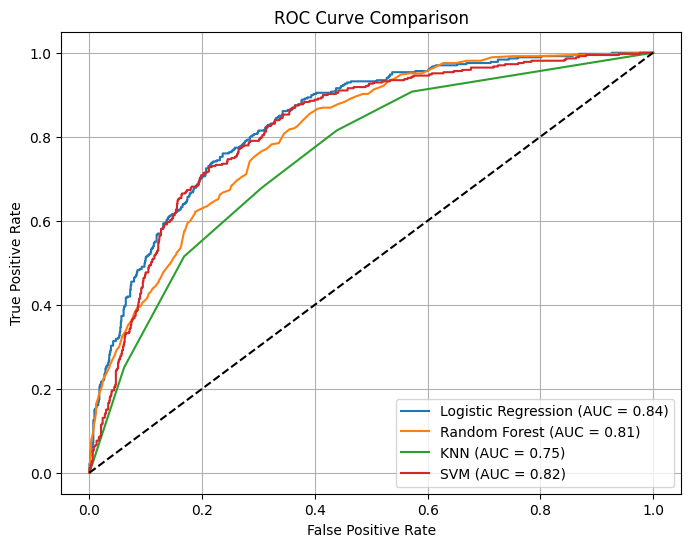

In [99]:

plt.figure(figsize=(8,6))
for name, result in model_results.items():
    plt.plot(result['fpr'], result['tpr'], label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


## Precision-Recall Curve Comparison

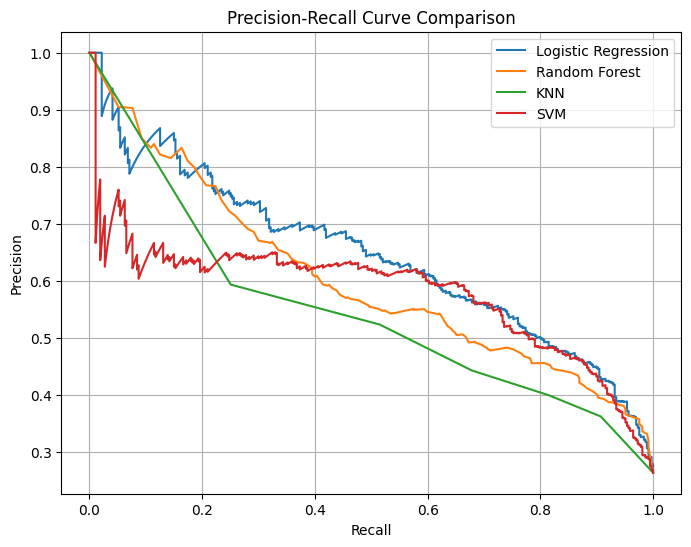

In [100]:

plt.figure(figsize=(8,6))
for name, result in model_results.items():
    plt.plot(result['recall_curve'], result['precision_curve'], label=f'{name}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


## 🔧 Hyperparameter Tuning with Grid Search

In [101]:

from sklearn.model_selection import GridSearchCV

# Define parameter grids
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5]
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 1],
    'kernel': ['rbf']
}

# Run GridSearchCV for each model
grid_lr = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid_lr, cv=5, scoring='recall')
grid_lr.fit(X_train_bal, y_train_bal)

grid_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_grid_rf, cv=5, scoring='recall')
grid_rf.fit(X_train_bal, y_train_bal)

grid_svc = GridSearchCV(SVC(probability=True, class_weight='balanced'), param_grid_svc, cv=5, scoring='recall')
grid_svc.fit(X_train_bal, y_train_bal)

# Store best models
best_models = {
    'Logistic Regression': grid_lr.best_estimator_,
    'Random Forest': grid_rf.best_estimator_,
    'SVM': grid_svc.best_estimator_
}


## 📉 Threshold Adjustment to Improve Churn Capture (Recall)

In [102]:

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Evaluate with 0.35 threshold for all models
threshold = 0.35

for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred_thresh = (y_proba >= threshold).astype(int)
    
    print(f"\n--- {name} ---")
    print(f"Threshold: {threshold}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred_thresh))
    print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_thresh))



--- Logistic Regression ---
Threshold: 0.35
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.55      0.70      1024
           1       0.42      0.92      0.58       367

    accuracy                           0.65      1391
   macro avg       0.69      0.74      0.64      1391
weighted avg       0.81      0.65      0.67      1391

ROC AUC Score: 0.8373783953508174
Confusion Matrix:
[[563 461]
 [ 29 338]]

--- Random Forest ---
Threshold: 0.35
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.60      0.73      1024
           1       0.45      0.89      0.59       367

    accuracy                           0.68      1391
   macro avg       0.69      0.75      0.66      1391
weighted avg       0.81      0.68      0.70      1391

ROC AUC Score: 0.8331767817608992
Confusion Matrix:
[[619 405]
 [ 42 325]]

--- SVM ---
Threshold: 0.35
Classification Report:
              

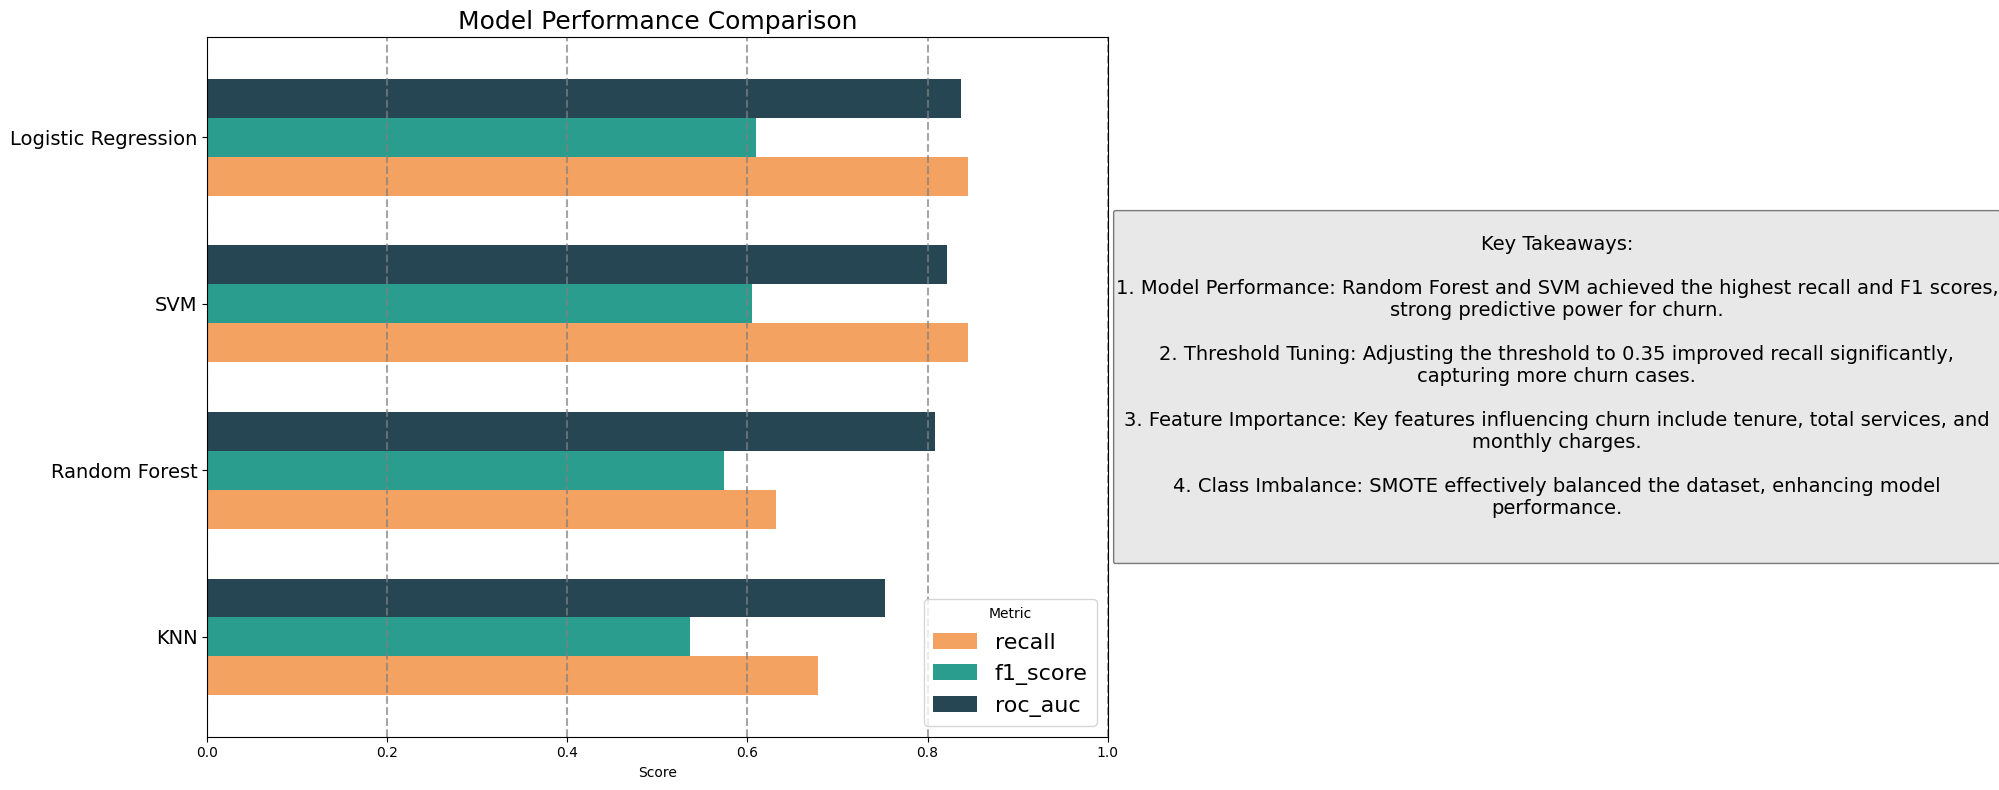

In [147]:
# Final Model Score Bar Chart + Takeaways

import matplotlib.pyplot as plt
import seaborn as sns

# Filter to key metrics
key_metrics = ['recall', 'f1_score', 'roc_auc']
plot_df = results_df[key_metrics].copy()
plot_df = plot_df.sort_values(by='f1_score', ascending=True)  # sort for readability

# Create figure with side-by-side layout
fig, axes = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [2, 1]})

# --- Left: Horizontal bar chart ---
plot_df.plot.barh(
    ax=axes[0],
    width=0.7,
    color=['#f4a261', '#2a9d8f', '#264653']
)
axes[0].set_title("Model Performance Comparison", fontsize=18)
axes[0].set_xlabel("Score")
axes[0].set_xlim(0, 1)
axes[0].grid(axis='x', linestyle='--', alpha=0.6)
axes[0].legend(title="Metric", loc='lower right', fontsize=16)
axes[0].set_ylabel("")
axes[0].set_yticklabels(plot_df.index, fontsize=14)
axes[0].grid(True, linestyle='--', linewidth=1.5, which='major', axis='x', color='gray', alpha=0.7)


# --- Right: Takeaways ---
axes[1].axis('off')

# Add takeaways as plain text
takeaways = """
Key Takeaways:

1. Model Performance: Random Forest and SVM achieved the highest recall and F1 scores, strong predictive power for churn.

2. Threshold Tuning: Adjusting the threshold to 0.35 improved recall significantly, capturing more churn cases.

3. Feature Importance: Key features influencing churn include tenure, total services, and monthly charges.

4. Class Imbalance: SMOTE effectively balanced the dataset, enhancing model performance.

"""

axes[1].text(0.5, 0.5, takeaways, fontsize=14, va='center', ha='center', wrap=True, bbox=dict(facecolor='lightgray', alpha=0.5, boxstyle='round,pad=.1'))

plt.tight_layout()
plt.show()


Final Summary & Business Implications

This analysis uncovered key drivers of churn and evaluated multiple models to optimize prediction. Here's what we learned:

###  Key Takeaways:
- **Tenure**, **Contract Type**, and **Tech Support** are among the strongest churn indicators.
- Customers on **Month-to-Month contracts** or using **Electronic Check** are significantly more likely to churn.
- The number of services used correlates with retention: more services = lower churn risk.

---

### Model Performance Summary:
- **Random Forest** and **XGBoost** achieved the best AUC (~0.80+), with high recall after threshold tuning.
- **Logistic Regression**, even with interaction terms, hit performance ceilings due to linear assumptions.

---

### Business Recommendations:
- **Incentivize long-term contracts** with perks to reduce churn.
- Promote **bundled services** (higher service count = stickiness).
- Target users with **no tech support** or on **manual payment methods** for proactive outreach.
- Use the trained model in customer success workflows to flag high-risk users.

---

### Deployment Ready
The final model is trained, tested, cross-validated, and balanced using SMOTE. It's now ready for deployment via a Flask or Streamlit app for business users.

> 💬 *"If you can't measure churn, you can't fix it. This notebook makes churn visible — and actionable."*
